In [8]:
'''
Vision label swap exps
'''

import importlib
import numpy as np
from tqdm.auto import tqdm
import pickle

import hydra
import logging

from prol.process import (
    get_cycle,
    get_torch_dataset,
    get_task_indicies_and_map,
    get_sequence_indices
)
from prol.utils import get_dataloader

import torch

In [9]:
class SetParams:
    def __init__(self, dict) -> None:
        for k, v in dict.items():
            setattr(self, k, v)

def get_modules(name):
    try: 
        module1 = importlib.import_module(f"prol.models.{name}")
        module2 = importlib.import_module(f"prol.datahandlers.{name}_handle")
    except ImportError:
        print(f"Module {name} not found")
    return module1, module2

In [11]:
log = logging.getLogger(__name__)

logging.basicConfig(filename='dev.log', level=logging.INFO)

# input parameters
params = {
    # dataset
    "dataset": "cifar-10",
    "task": [[0, 1]],    # task specification

    # experiment
    "method": "proformer",         # select from {proformer, cnn, mlp, timecnn}
    "N": 20,                     # time between two task switches                   
    "t": 100,                  # training time
    "T": 5000,                   # future time horizon
    "seed": 1996,   
    "device": "cuda:0",          # device
    "reps": 100,                 # number of test reps
    "outer_reps": 1,         
    
    # proformer
    "proformer" : {
        "contextlength": 200, 
        "encoding_type": 'freq',      
        "multihop": True
    },

    # timecnn
    "timecnn": {
        "encoding_type": 'freq', 
    },
            
    # training params
    "lr": 1e-3,         
    "batchsize": 64,
    "epochs": 500,
    "verbose": True
}
args = SetParams(params)
log.info(f'{params}')

# get source dataset
root = '/cis/home/adesilva/ashwin/research/ProL/data'
torch_dataset = get_torch_dataset(root, name=args.dataset)

# get indices for each task
taskInd, maplab, dummylab = get_task_indicies_and_map(
    tasks=args.task,
    y=torch_dataset.targets.numpy(),
    type='label-swap'
)

# modify the source dataset (assign dummy labels to half of the task labels)
torch_dataset.targets[taskInd[1]] = torch_dataset.targets[taskInd[1]].apply_(dummylab)

log.info(" ")
    
# get a training sequence
seed = args.seed * 2357
train_SeqInd, updated_taskInd = get_sequence_indices(
    N=args.N, 
    total_time_steps=args.t, 
    tasklib=taskInd, 
    seed=seed,
    remove_train_samples=True
)


# # get the module for the specified method
# method, datahandler = get_modules(args.method)

# # form the train dataset
# data_kwargs = {
#     "dataset": torch_dataset, 
#     "seqInd": train_SeqInd, 
#     "maplab": maplab
# }
# train_dataset = datahandler.VisionSequentialDataset(args, **data_kwargs)

# # model
# model_kwargs = method.model_defaults(args.dataset)
# if args.method == 'proformer':
#     model_kwargs['encoding_type'] = args.proformer['encoding_type']
# elif args.method == 'timecnn':
#     model_kwargs['encoding_type'] = args.timecnn['encoding_type']
# log.info(f'{model_kwargs}')
# model = method.Model(
#     num_classes=len(args.task[0]),
#     **model_kwargs
# )
    
# # train
# trainer = method.Trainer(model, train_dataset, args)
# trainer.fit(log)

Files already downloaded and verified


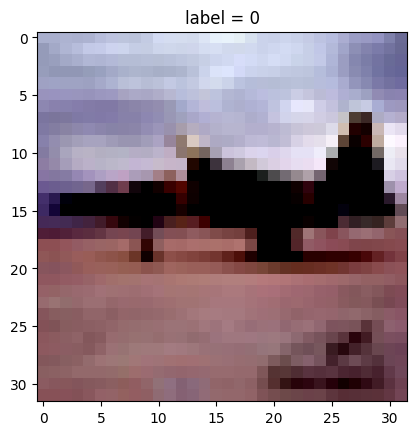

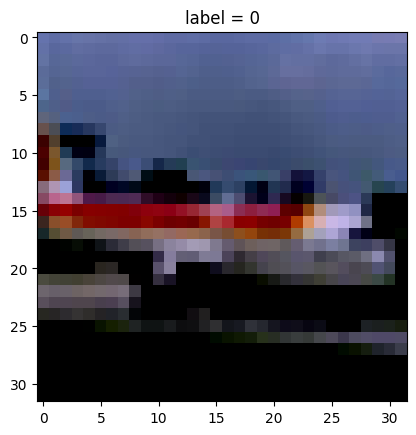

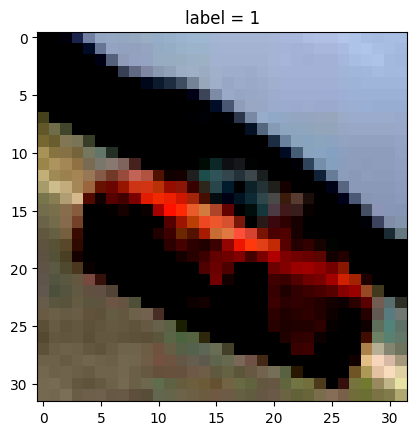

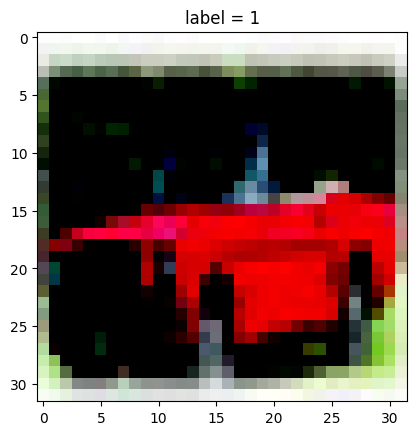

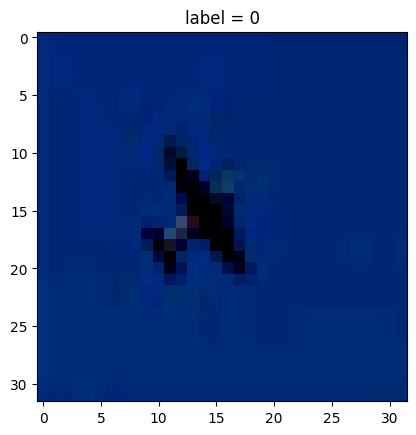

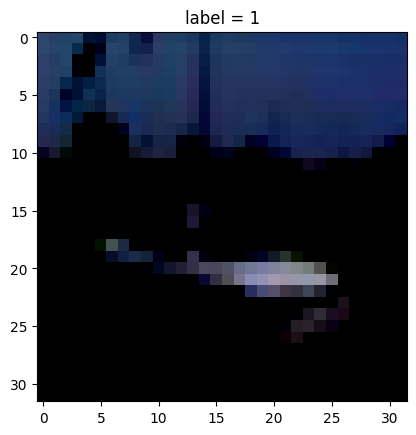

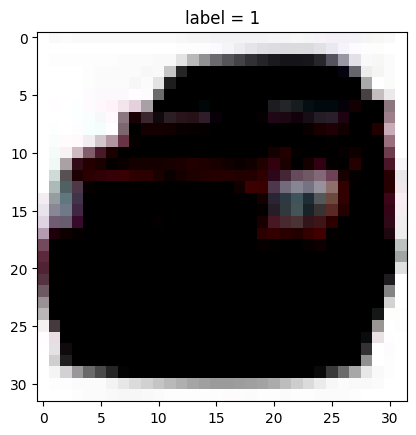

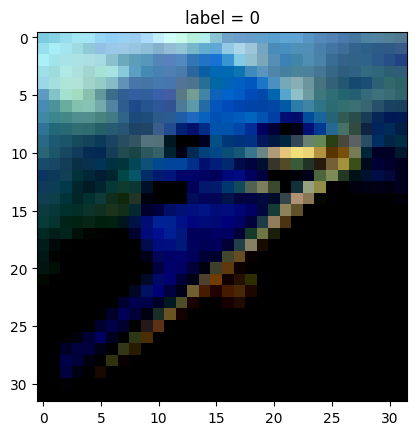

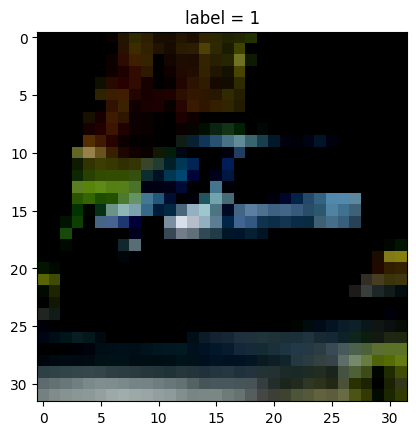

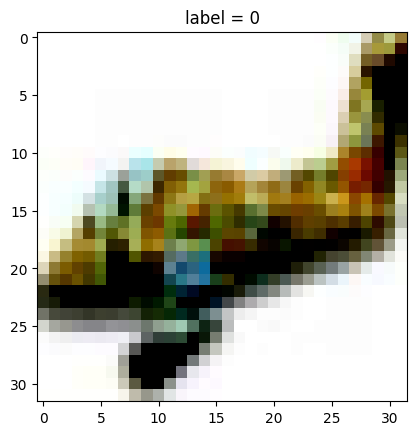

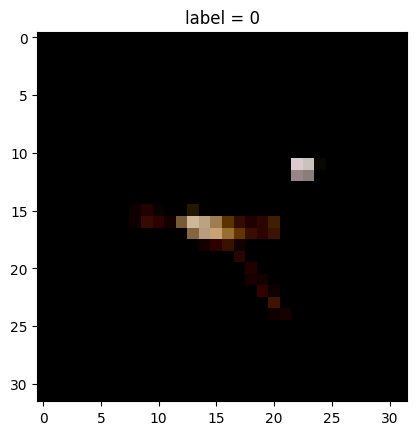

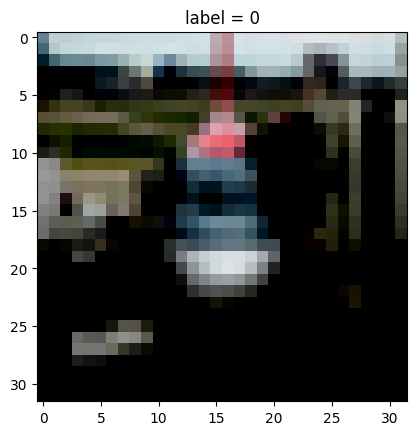

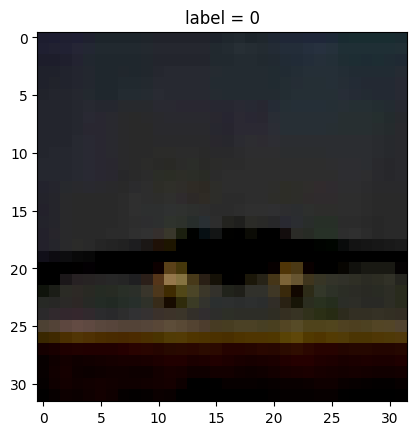

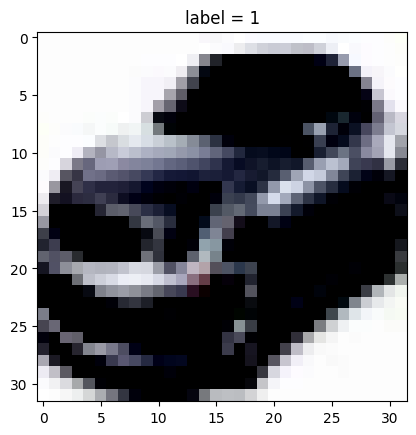

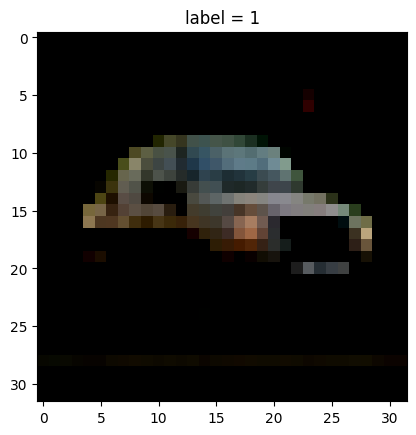

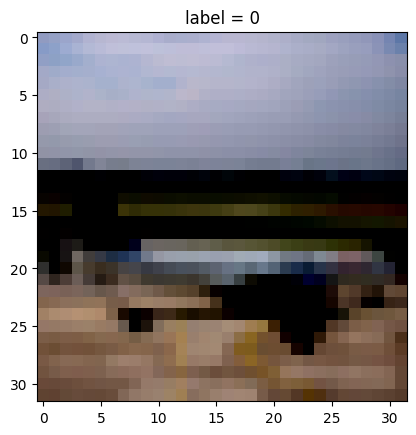

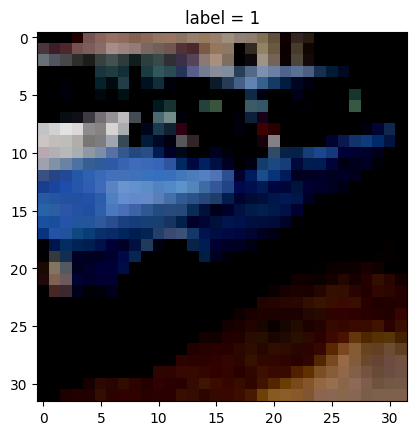

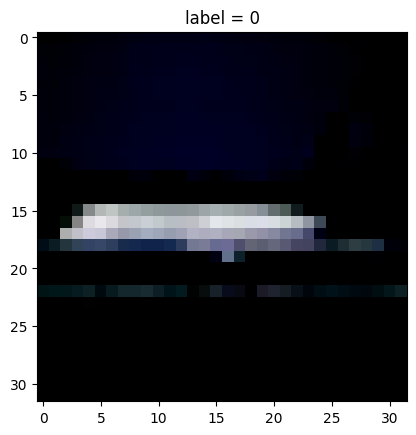

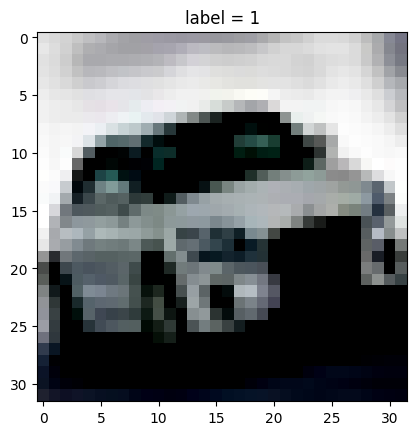

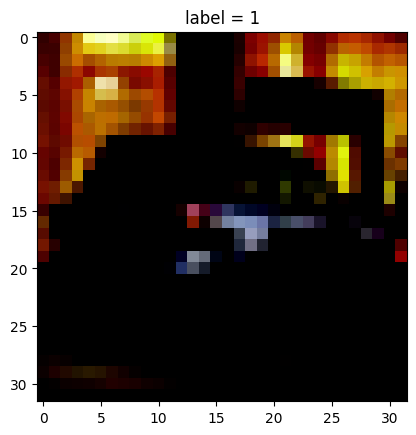

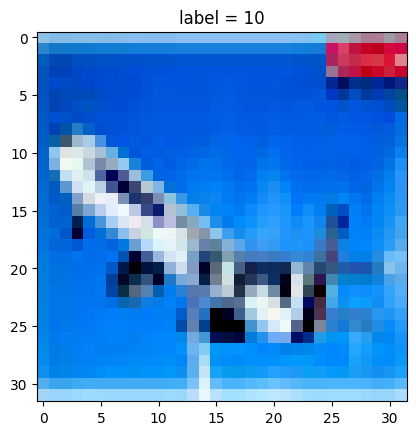

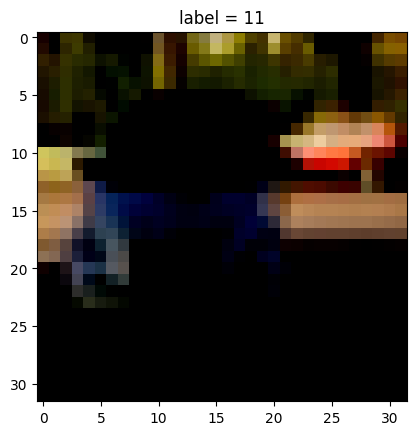

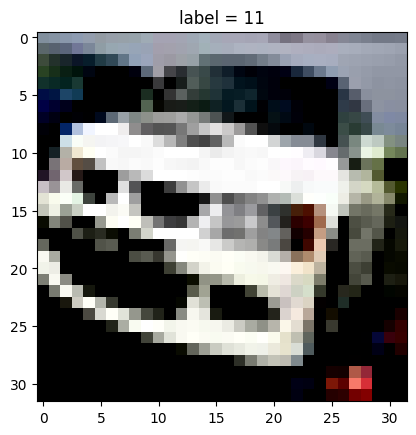

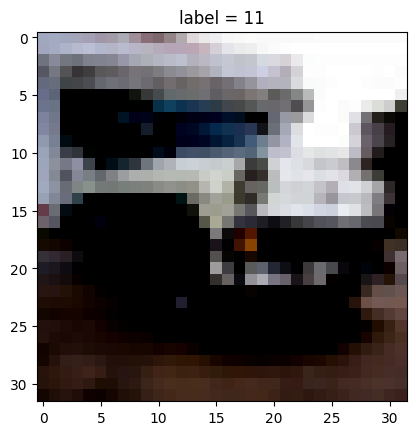

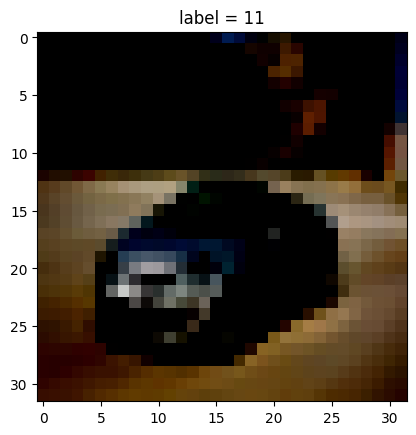

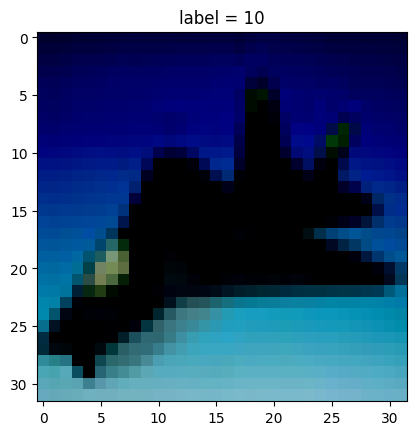

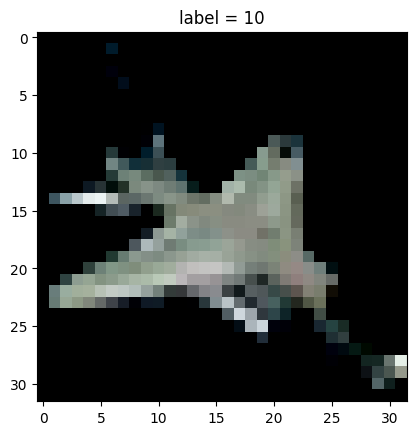

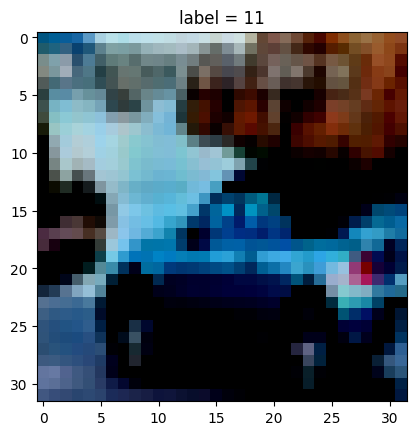

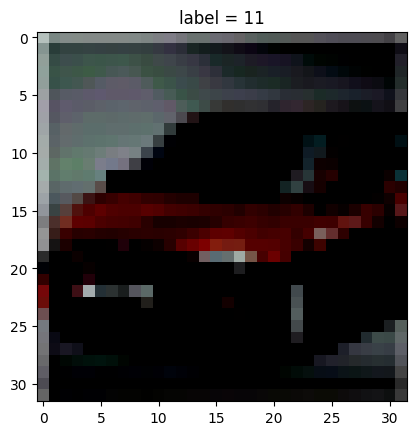

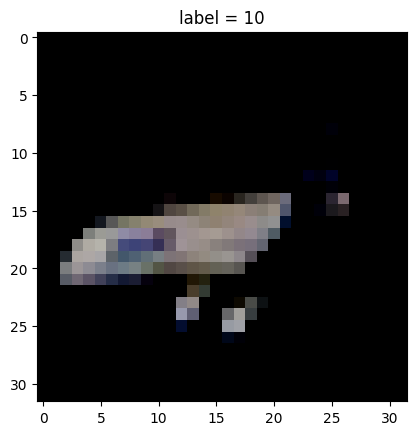

In [15]:
import matplotlib.pyplot as plt
for data, lab in zip(torch_dataset.data[train_SeqInd[:30]], torch_dataset.targets[train_SeqInd[:30]]):
    plt.imshow(data.squeeze())
    plt.title(f'label = {lab}')
    plt.show()